  Activating project at `~/Desktop/Desktop - Peter’s MacBook Air/Harvard/2.5/PRISE/Project/MatchgateGAN`


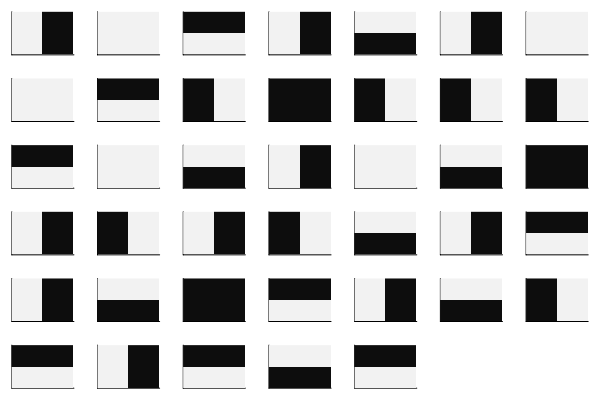

In [ ]:
using Pkg
Pkg.activate("/Users/pluo/Desktop/Desktop - Peter’s MacBook Air/Harvard/2.5/PRISE/Project/MatchgateGAN")

using Random
using Plots
using JLD2

n = 3 #Images are nxn
nq = n^2
train = 200 #Number of training data samples

#if repeats = false, need to find a way to not have duplicates
#check if train < 2^(n+1) - 2?

function bars_and_stripes(train = 10, repeats = true) #Samples 'train' data samples from the nxn bars_and_stripes synthetic dataset uniformly and with replacement if 'repeats' = true
    data = []
    for i in 1:train
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n #If it's all black or all white
            ret = flip ? b : .!b
        else #If not monochromatic, then it's vertical/horizontal with 1/2 probability
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

# directory = joinpath(pwd(), "diagnostics")

# display = JLD2.load(joinpath(directory, "dataset.jld2"))["data_train"] #Stores data in data_train
display = bars_and_stripes(train)
data_train = display .|> vec

Plots.plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in display]...)

In [23]:
#Initializing the discriminator and displaying details
using Flux
using JLD2

function MyModel()
    return Chain(Dense(nq, 100, relu), Dense(100, 1, sigmoid))
end

d = MyModel()

# model_state = JLD2.load(joinpath(directory, "model.jld2"), "model_state");
# d = MyModel(); # MyModel definition must be available
# Flux.loadmodel!(d, model_state)
# d = Chain(
#     Conv((2, 2), 1=>16, relu),    # 1 input channel, 16 output channels
#     MaxPool((2, 2)),
#     Conv((2, 2), 16=>32, relu),
#     # MaxPool((2, 2)),
#     Flux.flatten,
#     Dense(32, 100, relu),
#     Dense(100, 1),
#     sigmoid
# )
# # Dense((n ÷ 4 - 3) * (n ÷ 4 - 3) * 32, 100, relu)
println("Number of parameters in discriminator: ", sum(length, Flux.params(d)))

Number of parameters in discriminator: 601


In [ ]:
# Constructs a quantum circuit g with parameters θ, then differentiates the recursive algorithm given in Section 5.1 of https://arxiv.org/abs/1112.2184 to obtain the gradient of p_θ(x) wrt θ, where x is a measurement of g|0>. The differentiation takes polynomial time due to memoization.
# We then compare our results to the finite difference gradient
using Yao, FLOYao
using LinearAlgebra

function create_circuit(nq::Int)
    layers = 20 #Number of brick-wall layers in the circuit
    g = chain(nq)
    for _ in 1:layers
        for i in 1:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Nearest-neighbor XX rotation gates
        end
        for i in 2:2:nq-1
            push!(g, rot(kron(nq, i => X, i+1 => Y), 0.)) #Nearest-neighbor XY rotation gates
        end
        for i in 1:nq
            push!(g, put(nq, i => Rz(0.))) #Single qubit Z rotation gates
        end
    end
    return g
end

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns (im/2)γ_iγ_j, assuming that i≠j
    p = []
    c = (i % 2 == j % 2) ? 1 : -1
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = 1
        push!(p, first => Z)
    else
        if a % 2 == 0
            push!(p, first => X)
            c *= 1
        else
            push!(p, first => Y)
            c *= -1
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if b % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    if i > j
        c *= -1
    end
    return c*kron(nq, p...)
end

function majorana_commutator(nq, i, j) #Returns [γ_i,γ_j]=2γ_iγ_j, due to the anti-commutation of Majorana operators. It needs to be an 'Add' object so that the Yao.expect' function can take it in as input.
    return Add(majoranaindices2kron(nq, i, j)) 
end

function update_opt!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    dim = 2*nq
    for i in 1:nq
        if i > 1
            ni = b[i-1]
            cur_prob = probabilities[i-1]
            cur_grad_prob = grad_probabilities[:, i-1]
            cur_prefactor = (-1)^ni / (2*cur_prob)
            cur_grad_prefactor = (-1)^ni / (2*cur_prob^2)
            @inbounds for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    for s in size(temp_grad_m, 1)
                        temp_grad_m[s,p,q] -= cur_grad_prefactor * ((-cur_grad_prob[s] * temp_m[2*(i-1)-1,p] * temp_m[2*(i-1),q]) + (cur_prob * (temp_grad_m[s, 2*(i-1)-1,p] * temp_m[2*(i-1),q] + temp_m[2*(i-1)-1,p] * temp_grad_m[s,2*(i-1),q])))
                        temp_grad_m[s,p,q] += cur_grad_prefactor * ((-cur_grad_prob[s] * temp_m[2*(i-1)-1,q] * temp_m[2*(i-1),p]) + (cur_prob * (temp_grad_m[s, 2*(i-1)-1,q] * temp_m[2*(i-1),p] + temp_m[2*(i-1)-1,q] * temp_grad_m[s,2*(i-1),p])))
                    end
                end
            end
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_m[p,q] -= cur_prefactor * (temp_m[2*(i-1)-1,p] * temp_m[2*(i-1),q])
                    temp_m[p,q] += cur_prefactor * (temp_m[2*(i-1)-1,q] * temp_m[2*(i-1),p])
                end
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            temp_m = covariance_matrix(apply(reg, g))
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q)
                    temp_grad_m[:,p,q] = expect'(ham, reg => g)[2]
                end
            end
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        end
    end
end

function log_grad_opt(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities) #Returns ∇_θlog(p_θ(b)), evaluated at 'theta' (parameters of circuit) and 'b' (measurement result); 'reg' is the initial register and must be of type MajoranaReg (e.g. FLOYao.zero_state(nq)). 
    update_opt!(reg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[:, i] / probabilities[i]
    end
    return probabilities, s
end

using Yao.BitBasis
using Flux

function postprocess(g_output::Vector) #turns output of measure  into an Int vector
    result = []
    for i in 1:nq
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function d_postprocess(measurement::Vector)
    l = length(measurement)
    aa = breflect.(measurement)
    ret = Matrix(undef, nq, l)
    for i in 1:l
        ret[:,i] = [aa[i]...]
    end
    return ret
end

function g_loss(reg, theta, nbatch)
    dispatch!(g, theta)
    measurements = measure(reg, nshots = nbatch)
    discriminator_output = log.(d(d_postprocess(measurements, nbatch)))
    probs = Vector{Float64}(undef, nbatch)
    for i in 1:nbatch
        probs[i] = FLOYao.bitstring_probability(reg, measurements[i])    
    end
    return -discriminator_output * probs |> first
end

function d_loss(model, real, fake)
    -(log.(model(real)) + log.(1 .- model(fake))) |> first
end

function reinforce_grad_loss(reg, theta, nbatch)
    dispatch!(g, theta)
    T = Float64
    sampled = Dict{BitStr{nq, BigInt}, Vector{T}}()
    measurements = measure(apply(reg, g), nshots = nbatch)
    arr = d(d_postprocess(measurements))
    if 0 in arr #Replacing any 0's with the minimum value in discriminator_output
        m = minimum(filter(x -> x > 0, arr))
        for i in 1:size(arr, 2)
            if arr[i] == 0
                arr[i] = m
            end
        end
    end
    discriminator_output = log.(arr)
    #Initializing temporary matrices and vectors for the optimized version of the algorithm. Note: Do NOT need to reset these temporary matrices at the end of each iteration of the for loop.
    dim = 2*nq
    nparams = nparameters(g)
    temp_m = Matrix{T}(undef, dim, dim)
    temp_grad_m = Array{T}(undef, nparams, dim, dim)
    probabilities = Vector{T}(undef, nq)
    grad_probabilities = Matrix{T}(undef, nparams, nq)
    grad_p = Matrix{T}(undef, nparams, nbatch)
    for i in 1:nbatch
        cur_bitstr = measurements[i]
        if haskey(sampled, cur_bitstr)
            grad_p[:,i] = sampled[cur_bitstr]
        else
            _, log_grad = log_grad_opt(FLOYao.zero_state(nq), theta, cur_bitstr, temp_m, temp_grad_m, probabilities, grad_probabilities)
            grad_p[:,i] = log_grad
            sampled[cur_bitstr] = log_grad
        end
    end
    return -vec(mean(discriminator_output.*grad_p, dims = 2))
end
mean(x; dims) = sum(x; dims)/length(x)

g = create_circuit(nq)
p = rand(nparameters(g)).*2π
println("Number of parameters in generator: ", nparameters(g))
# dispatch!(g, p);

# p = JLD2.load(joinpath(directory, "gparams.jld2"))
# p = p["gparams"]
# print(p)
dispatch!(g, p);

Number of parameters in generator: 140


In [ ]:
using Flux
using JLD2

g_lr = 1e-3
optimizer = Adam()
opt = Flux.setup(optimizer, d)

epochs = 2000
n_g = 10
n_d = 1
T = Float64
lossd_vals = Vector{T}(undef, epochs * n_d)
lossg_vals = Vector{T}(undef, epochs * n_g)
grad_norms = Vector{T}(undef, epochs * n_g)
mod = div(epochs, 20)
nshots = 100 #The size of the sample mean used in estimating the gradient and also in pooling the training and fake data
for i in 1:epochs
    t = time()
    for d_epoch in 1:n_d
        real = []
        for m in 0:nshots-1
            push!(real, Int.(data_train[(m % train) + 1]))
        end
        reg = apply(FLOYao.zero_state(nq), g)
        matrix = Int.(d_postprocess(measure(apply(FLOYao.zero_state(nq), g), nshots = nshots)))
        fake = [collect(matrix[:, i]) for i in 1:size(matrix, 2)]
        data = collect(zip(real, fake)) 
        Flux.train!(d_loss, d, data, opt)
        s = 0
        for x in data
            s += d_loss(d, x[1], x[2])        
        end
        lossd_vals[n_d*(i-1) + d_epoch] = s
    end
    for g_epoch in 1:n_g
        #Gradient descent
        theta = parameters(g)
        ∇ = reinforce_grad_loss(FLOYao.zero_state(nq), theta, nshots)
        grad_norms[n_g*(i-1) + g_epoch] = norm(∇)
        dispatch!(-, g, ∇ * g_lr)

        #Computing the loss of G
        reg = apply(FLOYao.zero_state(nq), g)
        measurements = measure(reg, nshots = nshots)
        discriminator_output = log.(d(d_postprocess(measurements)))
        lossg_vals[n_g*(i-1) + g_epoch] = -sum(discriminator_output) / nshots
    end
    if i % mod == 0
        println("time for epoch $i:", time() - t)
    end
end

directory = joinpath(pwd(), "diagnostics")
#Saving parameters of d and g
jldsave(joinpath(directory, "model.jld2"), model_state = Flux.state(d), opt_state = opt)

gparams = parameters(g)
@save joinpath(directory, "gparams.jld2") gparams

#Saving loss functions and other diagnostics
@save joinpath(directory, "lossg.jld2") lossg_vals
@save joinpath(directory, "lossd.jld2") lossd_vals
@save joinpath(directory, "gradnorms.jld2") grad_norms

time for epoch 100:0.5529320240020752
time for epoch 200:0.5397071838378906
time for epoch 300:0.5632240772247314
time for epoch 400:0.5653369426727295
time for epoch 500:0.5565221309661865
time for epoch 600:0.5671200752258301
time for epoch 700:0.5593719482421875
time for epoch 800:0.5770151615142822
time for epoch 900:0.5769820213317871
time for epoch 1000:0.5663580894470215
time for epoch 1100:0.5233249664306641
time for epoch 1200:0.6064651012420654
time for epoch 1300:0.479611873626709
time for epoch 1400:0.4800140857696533
time for epoch 1500:0.5020790100097656
time for epoch 1600:0.49435901641845703
time for epoch 1700:0.4704761505126953
time for epoch 1800:0.4833049774169922
time for epoch 1900:0.49494385719299316
time for epoch 2000:0.469343900680542


In [3]:
using JLD2

directory = joinpath(pwd(), "diagnostics")
@save joinpath(directory, "dataset.jld2") data_train

UndefVarError: UndefVarError: `data_train` not defined in `Main`
Suggestion: check for spelling errors or missing imports.